**Source of the materials**: Biopython cookbook (adapted)

In [1]:
#Lets load notebook's Image
from IPython.core.display import Image 

In [2]:
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO

# Graphics including GenomeDiagram

The Bio.Graphics module depends on the third party Python library ReportLab. Although focused on producing PDF files, ReportLab can also create encapsulated postscript (EPS) and (SVG) files. In addition to these vector based images, provided certain further dependencies such as the Python Imaging Library (PIL) are installed, ReportLab can also output bitmap images (including JPEG, PNG, GIF, BMP and PICT formats).

## GenomeDiagram

### Introduction

The **Bio.Graphics.GenomeDiagram** module was added to Biopython 1.50, having previously been available as a separate Python module dependent on Biopython.

As the name might suggest, GenomeDiagram was designed for drawing whole genomes, in particular prokaryotic genomes, either as linear diagrams (optionally broken up into fragments to fit better) or as circular wheel diagrams. It proved also well suited to drawing quite detailed figures for smaller genomes such as phage, plasmids or mitochrondia.

This module is easiest to use if you have your genome loaded as a SeqRecord object containing lots of SeqFeature objects - for example as loaded from a GenBank file.

### Diagrams, tracks, feature-sets and features

GenomeDiagram uses a nested set of objects. At the top level, you have a diagram object representing a sequence (or sequence region) along the horizontal axis (or circle). A diagram can contain one or more tracks, shown stacked vertically (or radially on circular diagrams). These will typically all have the same length and represent the same sequence region. You might use one track to show the gene locations, another to show regulatory regions, and a third track to show the GC percentage.

The most commonly used type of track will contain features, bundled together in feature-sets. You might choose to use one feature-set for all your CDS features, and another for tRNA features. This isn’t required - they can all go in the same feature-set, but it makes it easier to update the properties of just selected features (e.g. make all the tRNA features red).

There are two main ways to build up a complete diagram. Firstly, the top down approach where you create a diagram object, and then using its methods add track(s), and use the track methods to add feature-set(s), and use their methods to add the features. Secondly, you can create the individual objects separately (in whatever order suits your code), and then combine them.

### A top down example

We’re going to draw a whole genome from a SeqRecord object read in from a GenBank file. This example uses the pPCP1 plasmid from Yersinia pestis biovar Microtus (<a href="data/NC_005816.gb">NC_005816.gb</a>)

In [3]:
record = SeqIO.read("data/NC_005816.gb", "genbank")

We’re using a top down approach, so after loading in our sequence we next create an empty diagram, then add an (empty) track, and to that add an (empty) feature set:

In [4]:
gd_diagram = GenomeDiagram.Diagram("Yersinia pestis biovar Microtus plasmid pPCP1")
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

Now the fun part - we take each gene SeqFeature object in our SeqRecord, and use it to generate a feature on the diagram. We’re going to color them blue, alternating between a dark blue and a light blue.

In [5]:
for feature in record.features:
    if feature.type != "gene":
        #Exclude this feature
        continue
    if len(gd_feature_set) % 2 == 0:
        color = colors.blue
    else:
        color = colors.lightblue
    gd_feature_set.add_feature(feature, color=color, label=True)

Now we come to actually making the output file. This happens in two steps, first we call the draw method, which creates all the shapes using ReportLab objects. Then we call the write method which renders these to the requested file format. Note you can output in multiple file formats:

In [6]:
gd_diagram.draw(format="linear", orientation="landscape", pagesize='A4',
                fragments=4, start=0, end=len(record))
gd_diagram.write("data/plasmid_linear.png", "png")

Lets have a look at the previous one:
<img src="plasmid_linear.png">

Notice that the fragments argument which we set to four controls how many pieces the genome gets broken up into.

If you want to do a circular figure, then try this:

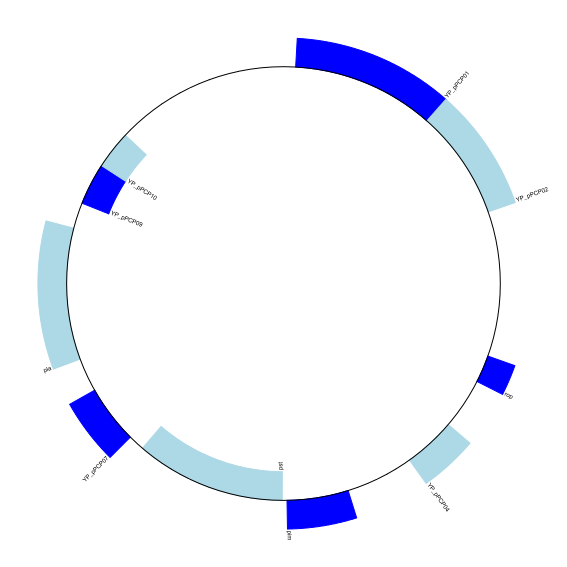

In [7]:
gd_diagram.draw(format="circular", circular=True, pagesize=(20*cm,20*cm),
                start=0, end=len(record), circle_core=0.7)
gd_diagram.write("data/plasmid_circular.png", "PNG")
Image("data/plasmid_circular.png")

These figures are not very exciting, but we’ve only just got started.

### A bottom up example

Now let’s produce exactly the same figures, but using the bottom up approach. This means we create the different objects directly (and this can be done in almost any order) and then combine them.

In [8]:
record = SeqIO.read("data/NC_005816.gb", "genbank")

#Create the feature set and its feature objects,
gd_feature_set = GenomeDiagram.FeatureSet()
for feature in record.features:
    if feature.type != "gene":
        #Exclude this feature
        continue
    if len(gd_feature_set) % 2 == 0:
        color = colors.blue
    else:
        color = colors.lightblue
    gd_feature_set.add_feature(feature, color=color, label=True)
#(this for loop is the same as in the previous example)

#Create a track, and a diagram
gd_track_for_features = GenomeDiagram.Track(name="Annotated Features")
gd_diagram = GenomeDiagram.Diagram("Yersinia pestis biovar Microtus plasmid pPCP1")

#Now have to glue the bits together...
gd_track_for_features.add_set(gd_feature_set)
gd_diagram.add_track(gd_track_for_features, 1)

You can now call the draw and write methods as before to produce a linear or circular diagram, using the code at the end of the top-down example above. The figures should be identical.

### Features without a SeqFeature

In the above example we used a SeqRecord’s SeqFeature objects to build our diagram. Sometimes you won’t have SeqFeature objects, but just the coordinates for a feature you want to draw. You have to create minimal SeqFeature object, but this is easy:

In [9]:
from Bio.SeqFeature import SeqFeature, FeatureLocation
my_seq_feature = SeqFeature(FeatureLocation(50,100),strand=+1)

For strand, use +1 for the forward strand, -1 for the reverse strand, and None for both. Here is a short self contained example:

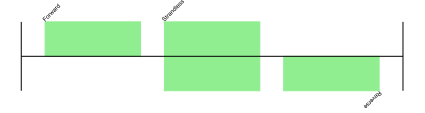

In [10]:
gdd = GenomeDiagram.Diagram('Test Diagram')
gdt_features = gdd.new_track(1, greytrack=False)
gds_features = gdt_features.new_set()

#Add three features to show the strand options,
feature = SeqFeature(FeatureLocation(25, 125), strand=+1)
gds_features.add_feature(feature, name="Forward", label=True)
feature = SeqFeature(FeatureLocation(150, 250), strand=None)
gds_features.add_feature(feature, name="Strandless", label=True)
feature = SeqFeature(FeatureLocation(275, 375), strand=-1)
gds_features.add_feature(feature, name="Reverse", label=True)

gdd.draw(format='linear', pagesize=(15*cm,4*cm), fragments=1,
         start=0, end=400)
gdd.write("data/GD_labels_default.png", "png")
Image("data/GD_labels_default.png")

The top part of the image in the next subsection shows the output (in the default feature color, pale green).

Notice that we have used the name argument here to specify the caption text for these features. This is discussed in more detail next.

### Feature captions

Recall we used the following (where feature was a SeqFeature object) to add a feature to the diagram:

In [11]:
gd_feature_set.add_feature(feature, color=color, label=True)

In the example above the SeqFeature annotation was used to pick a sensible caption for the features. By default the following possible entries under the SeqFeature object’s qualifiers dictionary are used: gene, label, name, locus_tag, and product. More simply, you can specify a name directly:

In [12]:
gd_feature_set.add_feature(feature, color=color, label=True, name="My Gene")

In addition to the caption text for each feature’s label, you can also choose the font, position (this defaults to the start of the sigil, you can also choose the middle or at the end) and orientation (for linear diagrams only, where this defaults to rotated by 45 degrees):

In [13]:
#Large font, parallel with the track
gd_feature_set.add_feature(feature, label=True, color="green",
                           label_size=25, label_angle=0)

#Very small font, perpendicular to the track (towards it)
gd_feature_set.add_feature(feature, label=True, color="purple",
                           label_position="end",
                           label_size=4, label_angle=90)

#Small font, perpendicular to the track (away from it)
gd_feature_set.add_feature(feature, label=True, color="blue",
                           label_position="middle",
                           label_size=6, label_angle=-90)

Combining each of these three fragments with the complete example in the previous section should give something like this:

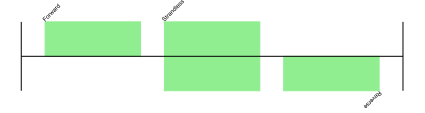

In [14]:
gdd.draw(format='linear', pagesize=(15*cm,4*cm), fragments=1,
         start=0, end=400)
gdd.write("data/GD_labels.png", "png")
Image("data/GD_labels.png")

We’ve not shown it here, but you can also set label_color to control the label’s color.

You’ll notice the default font is quite small - this makes sense because you will usually be drawing many (small) features on a page, not just a few large ones as shown here.

### Feature sigils

The examples above have all just used the default sigil for the feature, a plain box, which was all that was available in the last publicly released standalone version of GenomeDiagram. Arrow sigils were included when GenomeDiagram was added to Biopython 1.50:

In [15]:
#Default uses a BOX sigil
gd_feature_set.add_feature(feature)

#You can make this explicit:
gd_feature_set.add_feature(feature, sigil="BOX")

#Or opt for an arrow:
gd_feature_set.add_feature(feature, sigil="ARROW")

#Box with corners cut off (making it an octagon)
gd_feature_set.add_feature(feature, sigil="OCTO")

#Box with jagged edges (useful for showing breaks in contains)
gd_feature_set.add_feature(feature, sigil="JAGGY")

#Arrow which spans the axis with strand used only for direction
gd_feature_set.add_feature(feature, sigil="BIGARROW")

These are shown below. Most sigils fit into a bounding box (as given by the default BOX sigil), either above or below the axis for the forward or reverse strand, or straddling it (double the height) for strand-less features. The BIGARROW sigil is different, always straddling the axis with the direction taken from the feature’s stand.

### Arrow sigils

We introduced the arrow sigils in the previous section. There are two additional options to adjust the shapes of the arrows, firstly the thickness of the arrow shaft, given as a proportion of the height of the bounding box:

In [16]:
#Full height shafts, giving pointed boxes:
gd_feature_set.add_feature(feature, sigil="ARROW", color="brown",
                           arrowshaft_height=1.0)
#Or, thin shafts:                      
gd_feature_set.add_feature(feature, sigil="ARROW", color="teal",
                           arrowshaft_height=0.2)
#Or, very thin shafts:
gd_feature_set.add_feature(feature, sigil="ARROW", color="darkgreen",
                           arrowshaft_height=0.1)

The results are shown below:

Secondly, the length of the arrow head - given as a proportion of the height of the bounding box (defaulting to 0.5, or 50%):

In [17]:
#Short arrow heads:
gd_feature_set.add_feature(feature, sigil="ARROW", color="blue",
                           arrowhead_length=0.25)
#Or, longer arrow heads:
gd_feature_set.add_feature(feature, sigil="ARROW", color="orange",
                           arrowhead_length=1)
#Or, very very long arrow heads (i.e. all head, no shaft, so triangles):
gd_feature_set.add_feature(feature, sigil="ARROW", color="red",
                           arrowhead_length=10000)

The results are shown below:

Biopython 1.61 adds a new BIGARROW sigil which always stradles the axis, pointing left for the reverse strand or right otherwise:

In [18]:
#A large arrow straddling the axis:
gd_feature_set.add_feature(feature, sigil="BIGARROW")

All the shaft and arrow head options shown above for the ARROW sigil can be used for the BIGARROW sigil too.

### A nice example

Now let’s return to the pPCP1 plasmid from Yersinia pestis biovar Microtus, and the top down approach used above, but take advantage of the sigil options we’ve now discussed. This time we’ll use arrows for the genes, and overlay them with strand-less features (as plain boxes) showing the position of some restriction digest sites.

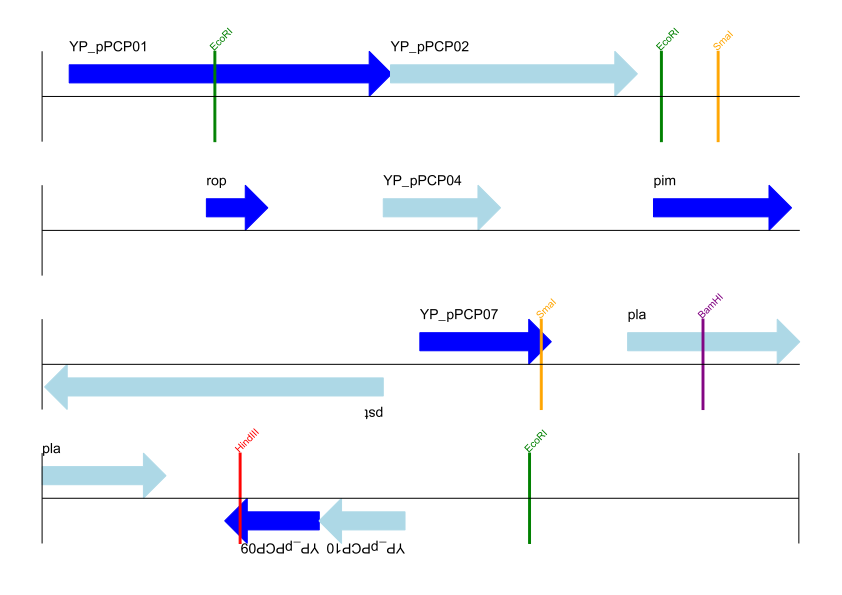

In [19]:
record = SeqIO.read("data/NC_005816.gb", "genbank")

gd_diagram = GenomeDiagram.Diagram(record.id)
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

for feature in record.features:
    if feature.type != "gene":
        #Exclude this feature
        continue
    if len(gd_feature_set) % 2 == 0:
        color = colors.blue
    else:
        color = colors.lightblue
    gd_feature_set.add_feature(feature, sigil="ARROW",
                               color=color, label=True,
                               label_size = 14, label_angle=0)

#I want to include some strandless features, so for an example
#will use EcoRI recognition sites etc.
for site, name, color in [("GAATTC","EcoRI",colors.green),
                          ("CCCGGG","SmaI",colors.orange),
                          ("AAGCTT","HindIII",colors.red),
                          ("GGATCC","BamHI",colors.purple)]:
    index = 0
    while True:
        index  = record.seq.find(site, start=index)
        if index == -1 : break
        feature = SeqFeature(FeatureLocation(index, index+len(site)))
        gd_feature_set.add_feature(feature, color=color, name=name,
                                   label=True, label_size = 10,
                                   label_color=color)
        index += len(site)

gd_diagram.draw(format="linear", pagesize='A4', fragments=4,
                start=0, end=len(record))
gd_diagram.write("data/plasmid_linear_nice.png", "png")

Image("data/plasmid_linear_nice.png")

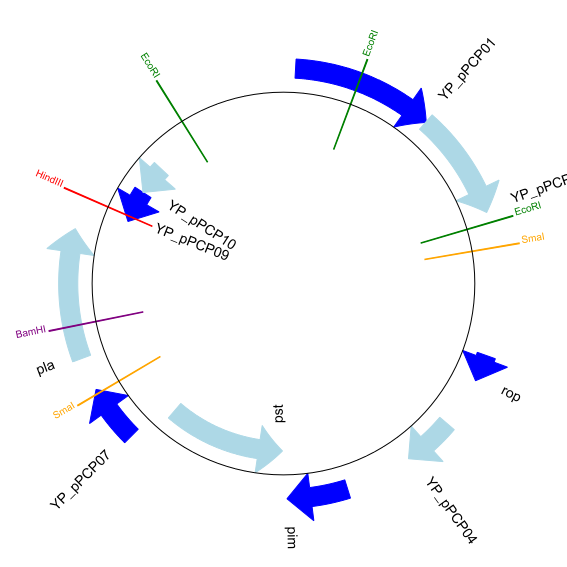

In [20]:
gd_diagram.draw(format="circular", circular=True, pagesize=(20*cm,20*cm),
                start=0, end=len(record), circle_core = 0.5)
gd_diagram.write("data/plasmid_circular_nice.png", "png")

Image("data/plasmid_circular_nice.png")

### Multiple tracks

All the examples so far have used a single track, but you can have more than one track – for example show the genes on one, and repeat regions on another. In this example we’re going to show three phage genomes side by side to scale, inspired by Figure 6 in Proux et al. (2002). We’ll need the GenBank files for the following three phage:

- NC_002703 – Lactococcus phage Tuc2009, complete genome (38347 bp)
- AF323668 – Bacteriophage bIL285, complete genome (35538 bp)
- NC_003212 – Listeria innocua Clip11262, complete genome, of which we are focussing only on integrated prophage 5 (similar length).

You can download these using Entrez if you like. For the third record we’ve worked out where the phage is integrated into the genome, and slice the record to extract it, and must also reverse complement to match the orientation of the first two phage:

In [21]:
A_rec = SeqIO.read("data/NC_002703.gbk", "gb")
B_rec = SeqIO.read("data/AF323668.gbk", "gb")
C_rec = SeqIO.read("data/NC_003212.gbk", "gb")[2587879:2625807].reverse_complement(name=True)

The figure we are imitating used different colors for different gene functions. One way to do this is to edit the GenBank file to record color preferences for each feature - something Sanger’s Artemis editor does, and which GenomeDiagram should understand. Here however, we’ll just hard code three lists of colors.

Note that the annotation in the GenBank files doesn’t exactly match that shown in Proux et al., they have drawn some unannotated genes.

In [22]:
from reportlab.lib.colors import red, grey, orange, green, brown, blue, lightblue, purple

A_colors = [red]*5 + [grey]*7 + [orange]*2 + [grey]*2 + [orange] + [grey]*11 + [green]*4 \
         + [grey] + [green]*2 + [grey, green] + [brown]*5 + [blue]*4 + [lightblue]*5 \
         + [grey, lightblue] + [purple]*2 + [grey]
B_colors = [red]*6 + [grey]*8 + [orange]*2 + [grey] + [orange] + [grey]*21 + [green]*5 \
         + [grey] + [brown]*4 + [blue]*3 + [lightblue]*3 + [grey]*5 + [purple]*2
C_colors = [grey]*30 + [green]*5 + [brown]*4 + [blue]*2 + [grey, blue] + [lightblue]*2 \
         + [grey]*5

Now to draw them – this time we add three tracks to the diagram, and also notice they are given different start/end values to reflect their different lengths.

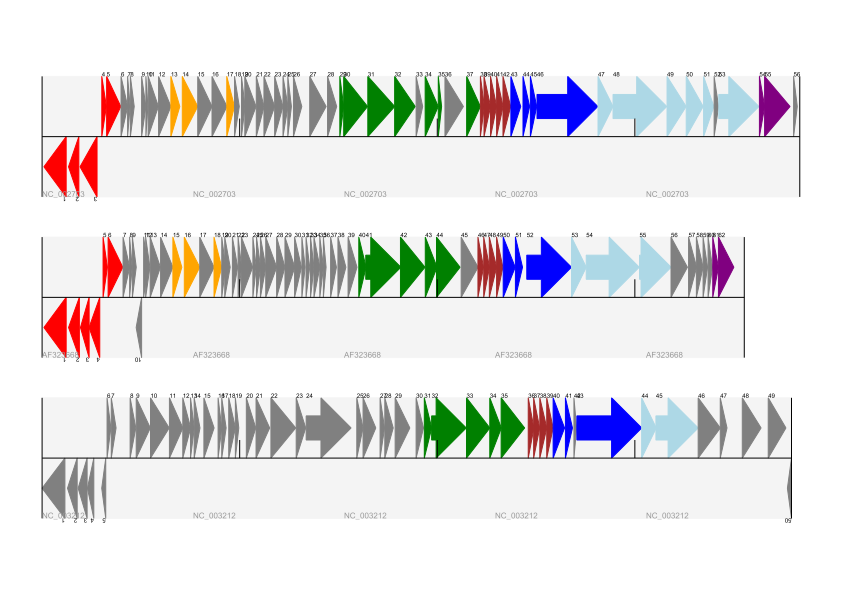

In [23]:
name = "data/Proux Fig 6"
gd_diagram = GenomeDiagram.Diagram(name)
max_len = 0
for record, gene_colors in zip([A_rec, B_rec, C_rec], [A_colors, B_colors, C_colors]):
    max_len = max(max_len, len(record))
    gd_track_for_features = gd_diagram.new_track(1,
                            name=record.name,
                            greytrack=True,
                            start=0, end=len(record))
    gd_feature_set = gd_track_for_features.new_set()

    i = 0
    for feature in record.features:
        if feature.type != "gene":
            #Exclude this feature                                                                                                   
            continue
        gd_feature_set.add_feature(feature, sigil="ARROW",
                                   color=gene_colors[i], label=True,
                                   name = str(i+1),
                                   label_position="start",
                                   label_size = 6, label_angle=0)
        i+=1

gd_diagram.draw(format="linear", pagesize='A4', fragments=1,
                start=0, end=max_len)
gd_diagram.write(name + ".png", "png")
Image(name + ".png")

I did wonder why in the original manuscript there were no red or orange genes marked in the bottom phage. Another important point is here the phage are shown with different lengths - this is because they are all drawn to the same scale (they are different lengths).

The key difference from the published figure is they have color-coded links between similar proteins – which is what we will do in the next section.

### Cross-Links between tracks

Biopython 1.59 added the ability to draw cross links between tracks - both simple linear diagrams as we will show here, but also linear diagrams split into fragments and circular diagrams.

Continuing the example from the previous section inspired by Figure 6 from Proux et al. 2002, we would need a list of cross links between pairs of genes, along with a score or color to use. Realistically you might extract this from a BLAST file computationally, but here I have manually typed them in.

My naming convention continues to refer to the three phage as A, B and C. Here are the links we want to show between A and B, given as a list of tuples (percentage similarity score, gene in A, gene in B).

In [24]:
#Tuc2009 (NC_002703) vs bIL285 (AF323668)
A_vs_B = [
    (99, "Tuc2009_01", "int"),
    (33, "Tuc2009_03", "orf4"),
    (94, "Tuc2009_05", "orf6"),
    (100,"Tuc2009_06", "orf7"),
    (97, "Tuc2009_07", "orf8"),
    (98, "Tuc2009_08", "orf9"),
    (98, "Tuc2009_09", "orf10"),
    (100,"Tuc2009_10", "orf12"),
    (100,"Tuc2009_11", "orf13"),
    (94, "Tuc2009_12", "orf14"),
    (87, "Tuc2009_13", "orf15"),
    (94, "Tuc2009_14", "orf16"),
    (94, "Tuc2009_15", "orf17"),
    (88, "Tuc2009_17", "rusA"),
    (91, "Tuc2009_18", "orf20"),
    (93, "Tuc2009_19", "orf22"),
    (71, "Tuc2009_20", "orf23"),
    (51, "Tuc2009_22", "orf27"),
    (97, "Tuc2009_23", "orf28"),
    (88, "Tuc2009_24", "orf29"),
    (26, "Tuc2009_26", "orf38"),
    (19, "Tuc2009_46", "orf52"),
    (77, "Tuc2009_48", "orf54"),
    (91, "Tuc2009_49", "orf55"),
    (95, "Tuc2009_52", "orf60"), 
]

Likewise for B and C:

In [25]:
#bIL285 (AF323668) vs Listeria innocua prophage 5 (in NC_003212)
B_vs_C = [
    (42, "orf39", "lin2581"),
    (31, "orf40", "lin2580"),
    (49, "orf41", "lin2579"), #terL
    (54, "orf42", "lin2578"), #portal
    (55, "orf43", "lin2577"), #protease
    (33, "orf44", "lin2576"), #mhp
    (51, "orf46", "lin2575"),
    (33, "orf47", "lin2574"),
    (40, "orf48", "lin2573"),
    (25, "orf49", "lin2572"),
    (50, "orf50", "lin2571"),
    (48, "orf51", "lin2570"),
    (24, "orf52", "lin2568"),
    (30, "orf53", "lin2567"),
    (28, "orf54", "lin2566"),
]

For the first and last phage these identifiers are locus tags, for the middle phage there are no locus tags so I’ve used gene names instead. The following little helper function lets us lookup a feature using either a locus tag or gene name:

In [26]:
def get_feature(features, id, tags=["locus_tag", "gene"]):
    """Search list of SeqFeature objects for an identifier under the given tags."""
    for f in features:
        for key in tags:
            #tag may not be present in this feature 
            for x in f.qualifiers.get(key, []):
                if x == id:
                     return f
    raise KeyError(id)

We can now turn those list of identifier pairs into SeqFeature pairs, and thus find their location co-ordinates. We can now add all that code and the following snippet to the previous example (just before the gd_diagram.draw(...) line – see the finished example script <a href="data/Proux_et_al_2002_Figure_6.py">Proux_et_al_2002_Figure_6.py</a> included in the Doc/examples folder of the Biopython source code) to add cross links to the figure:

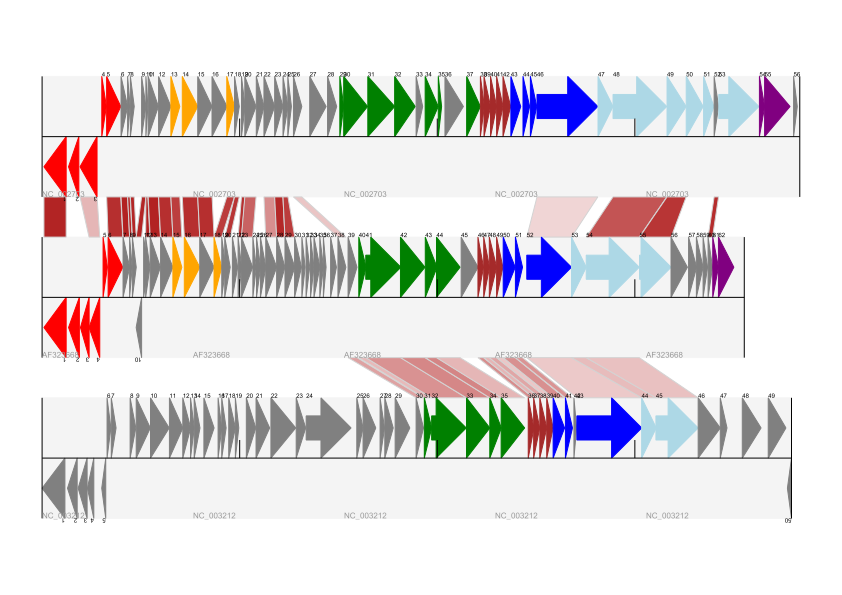

In [27]:
from Bio.Graphics.GenomeDiagram import CrossLink
from reportlab.lib import colors
#Note it might have been clearer to assign the track numbers explicitly...                                                          
for rec_X, tn_X, rec_Y, tn_Y, X_vs_Y in [(A_rec, 3, B_rec, 2, A_vs_B),
                                         (B_rec, 2, C_rec, 1, B_vs_C)]:
    track_X = gd_diagram.tracks[tn_X]
    track_Y = gd_diagram.tracks[tn_Y]
    for score, id_X, id_Y in X_vs_Y:
        feature_X = get_feature(rec_X.features, id_X)
        feature_Y = get_feature(rec_Y.features, id_Y)
        color = colors.linearlyInterpolatedColor(colors.white, colors.firebrick, 0, 100, score)
        link_xy = CrossLink((track_X, feature_X.location.start, feature_X.location.end),
                            (track_Y, feature_Y.location.start, feature_Y.location.end),
                            color, colors.lightgrey)
        gd_diagram.cross_track_links.append(link_xy)
gd_diagram.draw(format="linear", pagesize='A4', fragments=1,
                start=0, end=max_len)
gd_diagram.write("data/cross.png", "png")
Image("data/cross.png")

There are several important pieces to this code. First the GenomeDiagram object has a cross_track_links attribute which is just a list of CrossLink objects. Each CrossLink object takes two sets of track-specific co-ordinates (here given as tuples, you can alternatively use a GenomeDiagram.Feature object instead). You can optionally supply a colour, border color, and say if this link should be drawn flipped (useful for showing inversions).

You can also see how we turn the BLAST percentage identity score into a colour, interpolating between white (0%) and a dark red (100%). In this example we don’t have any problems with overlapping cross-links. One way to tackle that is to use transparency in ReportLab, by using colors with their alpha channel set. However, this kind of shaded color scheme combined with overlap transparency would be difficult to interpret. The result:

There is still a lot more that can be done within Biopython to help improve this figure. First of all, the cross links in this case are between proteins which are drawn in a strand specific manor. It can help to add a background region (a feature using the ‘BOX’ sigil) on the feature track to extend the cross link. Also, we could reduce the vertical height of the feature tracks to allocate more to the links instead – one way to do that is to allocate space for empty tracks. Furthermore, in cases like this where there are no large gene overlaps, we can use the axis-straddling BIGARROW sigil, which allows us to further reduce the vertical space needed for the track. These improvements are demonstrated in the example script <a href="data/Proux_et_al_2002_Figure_6.py">Proux_et_al_2002_Figure_6.py</a>.

Beyond that, finishing touches you might want to do manually in a vector image editor include fine tuning the placement of gene labels, and adding other custom annotation such as highlighting particular regions.

Although not really necessary in this example since none of the cross-links overlap, using a transparent color in ReportLab is a very useful technique for superimposing multiple links. However, in this case a shaded color scheme should be avoided.

## Chromosomes

The Bio.Graphics.BasicChromosome module allows drawing of chromosomes. There is an example in Jupe et al. (2012) (open access) using colors to highlight different gene families.

### Simple Chromosomes

**Important**: To continue this example you have first to download a few chromosomes from Arabidopsis thaliana, the code to help you is here:

**Very important**: This is slow and clogs the network, you only need to do this once (even if you close the notebook as the download will be persistent)

In [28]:
from ftplib import FTP
ftp = FTP('ftp.ncbi.nlm.nih.gov')
print("Logging in")
ftp.login()
ftp.cwd('genomes/Arabidopsis_thaliana')
print("Starting download - This can be slow!")
for chro, name in [
        ("CHR_I", "NC_003070.fna"), ("CHR_I", "NC_003070.gbk"),
        ("CHR_II", "NC_003071.fna"), ("CHR_II", "NC_003071.gbk"),
        ("CHR_III", "NC_003074.fna"), ("CHR_III", "NC_003074.gbk"),
        ("CHR_IV", "NC_003075.fna"), ("CHR_IV", "NC_003075.gbk"),
        ("CHR_V", "NC_003076.fna"), ("CHR_V", "NC_003076.gbk")]:
    print("Downloading", chro, name)
    ftp.retrbinary('RETR %s/%s' % (chro, name), open('data/%s' % name, 'wb').write)
ftp.quit()
print('Done')

Logging in
Starting download - This can be slow!
Done


Here is a very simple example - for which we’ll use Arabidopsis thaliana.

You can skip this bit, but first I downloaded the five sequenced chromosomes from the NCBI’s FTP site (per the code above) and then parsed them with Bio.SeqIO to find out their lengths. You could use the GenBank files for this, but it is faster to use the FASTA files for the whole chromosomes:

In [29]:
from Bio import SeqIO
entries = [("Chr I", "NC_003070.fna"),
           ("Chr II", "NC_003071.fna"),
           ("Chr III", "NC_003074.fna"),
           ("Chr IV", "NC_003075.fna"),
           ("Chr V", "NC_003076.fna")]
for (name, filename) in entries:
   record = SeqIO.read("data/" + filename, "fasta")
   print(name, len(record))

Chr I 30427671
Chr II 19698289
Chr III 23459830
Chr IV 18585056
Chr V 26975502


This gave the lengths of the five chromosomes, which we’ll now use in the following short demonstration of the BasicChromosome module:

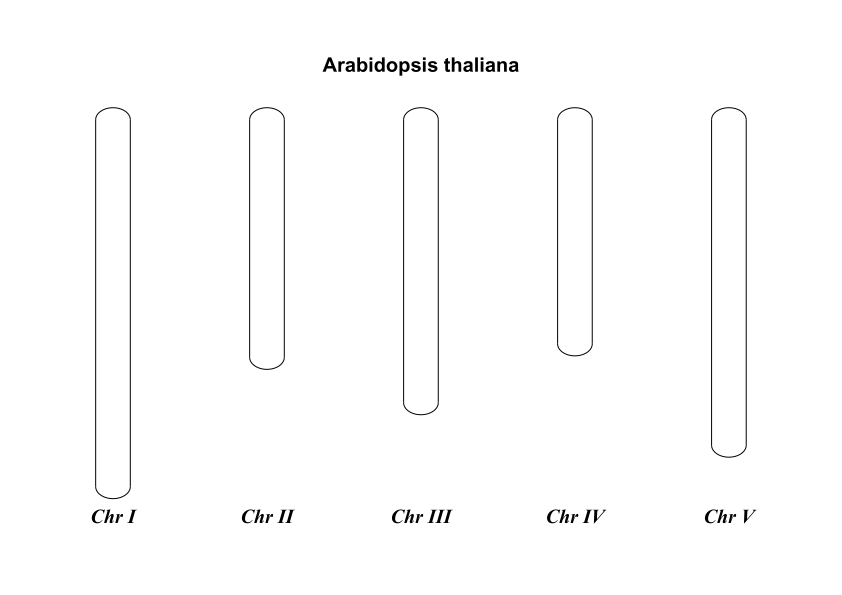

In [30]:
from reportlab.lib.units import cm
from Bio.Graphics import BasicChromosome

entries = [("Chr I", 30432563),
           ("Chr II", 19705359),
           ("Chr III", 23470805),
           ("Chr IV", 18585042),
           ("Chr V", 26992728)]

max_len = 30432563 #Could compute this
telomere_length = 1000000 #For illustration
         
chr_diagram = BasicChromosome.Organism(output_format="png")
chr_diagram.page_size = (29.7*cm, 21*cm) #A4 landscape

for name, length in entries:
    cur_chromosome = BasicChromosome.Chromosome(name)
    #Set the scale to the MAXIMUM length plus the two telomeres in bp,
    #want the same scale used on all five chromosomes so they can be
    #compared to each other
    cur_chromosome.scale_num = max_len + 2 * telomere_length

    #Add an opening telomere
    start = BasicChromosome.TelomereSegment()
    start.scale = telomere_length
    cur_chromosome.add(start)

    #Add a body - using bp as the scale length here.
    body = BasicChromosome.ChromosomeSegment()
    body.scale = length
    cur_chromosome.add(body)

    #Add a closing telomere
    end = BasicChromosome.TelomereSegment(inverted=True)
    end.scale = telomere_length
    cur_chromosome.add(end)

    #This chromosome is done
    chr_diagram.add(cur_chromosome)

chr_diagram.draw("data/simple_chrom.png", "Arabidopsis thaliana")
Image("data/simple_chrom.png")

This example is deliberately short and sweet. The next example shows the location of features of interest.

Continuing from the previous example, let’s also show the tRNA genes. We’ll get their locations by parsing the GenBank files for the five Arabidopsis thaliana chromosomes. You’ll need to download these files from the NCBI FTP site.

/home/tra/.local/lib/python3.4/site-packages/Bio/Graphics/BasicChromosome.py:529: BiopythonWarning: Too many labels to avoid overlap
  warnings.warn("Too many labels to avoid overlap", BiopythonWarning)


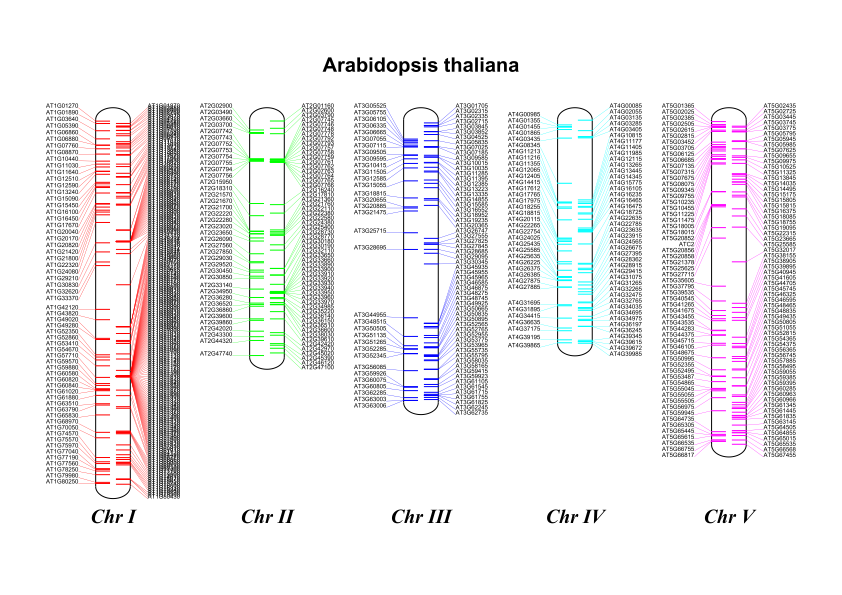

In [31]:
entries = [("Chr I", "NC_003070.gbk"),
           ("Chr II", "NC_003071.gbk"),
           ("Chr III", "NC_003074.gbk"),
           ("Chr IV", "NC_003075.gbk"),
           ("Chr V", "NC_003076.gbk")]

max_len = 30432563 #Could compute this
telomere_length = 1000000 #For illustration

chr_diagram = BasicChromosome.Organism(output_format="png")
chr_diagram.page_size = (29.7*cm, 21*cm) #A4 landscape

for index, (name, filename) in enumerate(entries):
    record = SeqIO.read("data/" + filename,"genbank")
    length = len(record)
    features = [f for f in record.features if f.type=="tRNA"]
    #Record an Artemis style integer color in the feature's qualifiers,
    #1 = Black, 2 = Red, 3 = Green, 4 = blue, 5 =cyan, 6 = purple 
    for f in features: f.qualifiers["color"] = [index+2]

    cur_chromosome = BasicChromosome.Chromosome(name)
    #Set the scale to the MAXIMUM length plus the two telomeres in bp,
    #want the same scale used on all five chromosomes so they can be
    #compared to each other
    cur_chromosome.scale_num = max_len + 2 * telomere_length

    #Add an opening telomere
    start = BasicChromosome.TelomereSegment()
    start.scale = telomere_length
    cur_chromosome.add(start)

    #Add a body - again using bp as the scale length here.
    body = BasicChromosome.AnnotatedChromosomeSegment(length, features)
    body.scale = length
    cur_chromosome.add(body)

    #Add a closing telomere
    end = BasicChromosome.TelomereSegment(inverted=True)
    end.scale = telomere_length
    cur_chromosome.add(end)

    #This chromosome is done
    chr_diagram.add(cur_chromosome)

chr_diagram.draw("data/tRNA_chrom.png", "Arabidopsis thaliana")
Image("data/tRNA_chrom.png")